### 모델 경량화 및 효율적인 트랜스포머 구축

1. **knowledge distillation** (지식 증류)
2. **quantization** (양자화)
3. **pruning** (가지치기)
4. Graph Optimization with **ONNX**

### 의도 탐지 (intent detection task)

- 경량화된 모델로 빠른 의도탐지를 하여 분류하여 원하는 정보를 고객에게 전달 <br>
    (ex.상담원 없이 챗봇으로 고객의 의도를 파악하여 계좌 정보를 제공 등)
- 사전 정의된 의도에 대한 쿼리가 저장되어있지 않으면 대체응답을 출력해야한다.

In [5]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt, device='cpu')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cpu


In [6]:
query = """hey, i'd like to rent a vehicle
from nov 1st to nov 15th in paris 
and i need a 15 passenger van"""

pipe(query)

[{'label': 'car_rental', 'score': 0.5490031838417053}]

In [7]:
# 데이터 셋 불러오기
from datasets import load_dataset
from evaluate import load

clinic = load_dataset("clinc_oos", "plus")
intents = clinic["test"].features["intent"]
sample_feature_int = clinic["test"][42]["intent"]

intents.int2str(sample_feature_int)

'transfer'

### 효율적인 밴치마크를 위한 함수정의

In [8]:
import torch
import numpy as np
from pathlib import Path
from time import perf_counter

class PerformanceBenchMark:
    def __init__(self, pipeline, dataset, optim_type = 'BERT baseline'):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
    
    # 모델 정확도 파악 함수
    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]['label']
            label = example['intent']
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = load("accuracy").compute(predictions=preds,references=labels)
        print(f"정확도 : {accuracy['accuracy']:3f}")
        return accuracy

    # 모델 사이즈 파악 함수
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt") # 임시 파일 생성
        torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink() # 임시 파일 삭제
        print(f"모델 크기 (mb) - {size_mb:.2f}")
        return {"size_mb" : size_mb}

    # 모델 소요 시간 파악 함수
    def time_pipeline(self, query="can i rent a EV?"):
        latencies = []
        # 워밍업
        for _ in range(10):
            _ = self.pipeline(query)
        # 실제 측정
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"평균 레이턴시(ms) : {time_avg_ms:.2f} +/- {time_std_ms:.2f} (표준편차) ")
        return {"time_avg_ms" :time_avg_ms,
                "time_std_ms":time_std_ms}
    
    # 총 모델의 벤치마크 함수
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        
        return metrics

In [9]:
pb = PerformanceBenchMark(pipe, clinic["test"])

In [10]:
perf_metrics = pb.run_benchmark()

모델 크기 (mb) - 418.15
평균 레이턴시(ms) : 33.84 +/- 8.77 (표준편차) 
정확도 : 0.867273


### Knowledge Distillation (지식 증류)
- **티쳐 모델의 확률 분포** ($ p_i $), **스튜던트 모델의 확률 분포** ($ q_i $)
- **Dark Knowledge**: 정답 레이블만으로는 얻을 수 없는 티쳐 모델의 부가적인 정보(예: 틀린 클래스들 간의 확률 관계).
- **Soft Probability**: 정답 레이블뿐 아니라 티쳐 모델의 확률 분포를 활용해 스튜던트 모델에 추가적인 정보를 전달.

<u> **Dark knowledge 가 있기 때문에 soft probability 를 활용해 모델 전달** </u>

- 과정
   1. **모델 출력 로짓 벡터**:
      $$
      z(x) = [z_1(x), z_2(x), ..., z_N(x)]
      $$

   2. **로짓 벡터에 소프트맥스 함수 적용**:  
      $$
      \text{Softmax}(z_i) = \frac{\exp(z_i)}{\sum_j \exp(z_j)}
      $$

   3. **소프트 확률 분포 생성**:  
      모델의 확률 분포를 "소프트하게" 만들기 위해, **온도 매개변수** $T$ 를 도입하여 소프트맥스에 적용<br>
      높은 확률 값을 낮추고, 낮은 확률 값을 높이는 효과:  
      $$
      p_i(x) = \frac{\exp(z_i(x)/T)}{\sum_j \exp(z_j(x)/T)}
      $$  
      여기서 $ T > 1 $일수록 분포가 더욱 완만.

   4. **KL Divergence로 확률 분포의 차이를 측정**:
      티쳐 모델의 확률 분포 $ p_i $와 스튜던트 모델의 확률 분포 $ q_i $ 간의 차이를 측정.: <br>
      여기서 KL Divergence 를 최소화 하는 것은, 우도의 최대화 <br>
      **두 확률분포의 차이를 최소화 = 두 확률분포의 같게함(?)을 최대화**
      $$
      D_{KL}(p || q) = \sum_i p_i(x) \log{\frac{p_i(x)}{q_i(x)}}
      $$

   5. **Knowledge Distillation 손실 ($ L_{KD} $)**:  
      온도 $ T $의 영향을 보정하기 위해 $ T^2 $를 곱한 형태로 KL Divergence를 계산.:  
      $$
      L_{KD} = T^2 \cdot \sum_i p_i(x) \log{\frac{p_i(x)}{q_i(x)}}
      $$

   6. **스튜던트 모델의 총 손실 ($ L_{student} $)**:  
      Knowledge Distillation에서 스튜던트 모델은 두 가지 손실의 가중합을 최소화.:  
      - **Cross-Entropy Loss** ($ L_{CE} $): 스튜던트 모델의 예측값과 실제 레이블 간의 손실.  
      - **Knowledge Distillation Loss** ($ L_{KD} $): 스튜던트 모델과 티쳐 모델의 확률 분포 간의 차이.  
      총 손실:
      $$
      L_{student} = \alpha L_{CE} + (1 - \alpha) L_{KD}
      $$  
      여기서 $ \alpha $는 두 손실의 가중치를 조절하는 하이퍼파라미터.

   ---

   <u>**즉, 스튜던트 모델의 손실은 기존 학습의 Cross-Entropy Loss와 티쳐 모델과의 KL Divergence 손실의 가중합으로 계산된다.**</u>

### KD(knoledge distillation) 을 위한 트레이너 만들기

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import TrainingArguments
from transformers import Trainer

class DistillationTrainingArguments(TrainingArguments): # 상속
    def __init__(self, *args, alpha=0.5, temperature = 2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)

        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 손실과 로짓
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        # 티처의 로짓
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        
        # 소프트 확률 계산
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [12]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinic_enc = clinic.map(tokenize_text, batched=True, remove_columns=["text"]) # 모델 입력 전처리
clinic_enc = clinic_enc.rename_column("intent","labels") # intent 컬럼을 모델에서 요구하는 labels 로 변경

In [13]:
from huggingface_hub import login
import json

with open("hf_key_token.json") as f:
    token = json.load(f)["hf_key_token"]

login(token)

In [14]:
# 정확도 측정
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    accuracy_metrics = load("accuracy")
    return accuracy_metrics.compute(predictions=predictions, references=labels)

### 스튜던트 모델 설정(with out knoledge distil)

In [15]:
# 훈련 args 설정
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinic-alpha_1"
student_training_args = DistillationTrainingArguments(
    output_dir = finetuned_ckpt,
    eval_strategy = "epoch",
    num_train_epochs = 5,
    learning_rate = 2e-5,
    per_device_train_batch_size = 48,
    per_device_eval_batch_size = 48,
    alpha=1, # 우선 Teacher 없이 훈련
    weight_decay = 0.01, # 가중치 크기 제한
    push_to_hub = True
)

In [16]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [17]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = AutoConfig.from_pretrained(student_ckpt,
                                            num_labels=num_labels,
                                            id2label=id2label,
                                            label2id=label2id)


In [18]:
device = torch.device("cpu")

In [19]:
import torch
from transformers import AutoModelForSequenceClassification

def student_init():
    return AutoModelForSequenceClassification.from_pretrained(student_ckpt,
                                                              config=student_config).to(device)

### 티쳐 로드 및 파인튜닝

In [20]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification.from_pretrained(teacher_ckpt,
                                                                    num_labels=num_labels)
                .to(device))

distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model,
                                         args = student_training_args,
                                         train_dataset = clinic_enc['train'],
                                         eval_dataset = clinic_enc['validation'],
                                         compute_metrics=compute_metrics,
                                         tokenizer=student_tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_16456/3768645800.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [416]:
distilbert_trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_5548/3768645800.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at d

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.296381,0.728065
2,3.799400,1.883754,0.843871
3,3.799400,1.172914,0.888387
4,1.711900,0.877697,0.912903
5,0.919300,0.793625,0.918710


TrainOutput(global_step=1590, training_loss=2.066276003279776, metrics={'train_runtime': 207.0963, 'train_samples_per_second': 368.186, 'train_steps_per_second': 7.678, 'total_flos': 414689637990180.0, 'train_loss': 2.066276003279776, 'epoch': 5.0})

In [417]:
distilbert_trainer.push_to_hub("training done knowledge distillation with 'alpha=1', means its not a KD")

model.safetensors: 100%|██████████| 268M/268M [00:18<00:00, 14.7MB/s] 


CommitInfo(commit_url='https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-clinic-alpha_1/commit/76defc55a1f0ec60a9163f5a95cbc1ec42751731', commit_message="training done knowledge distillation with 'alpha=1', means its not a KD", commit_description='', oid='76defc55a1f0ec60a9163f5a95cbc1ec42751731', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-clinic-alpha_1', endpoint='https://huggingface.co', repo_type='model', repo_id='tommyjin/distilbert-base-uncased-finetuned-clinic-alpha_1'), pr_revision=None, pr_num=None)

In [21]:
# model with out knoledge distil
finetuned_ckpt = "tommyjin/distilbert-base-uncased-finetuned-clinic-alpha_1"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=device)

optim_type="Distil_BERT_with_alpha_1"
pb = PerformanceBenchMark(pipe, clinic["test"],optim_type)

Device set to use cpu


In [22]:
perf_metrics.update(pb.run_benchmark())

모델 크기 (mb) - 255.88
평균 레이턴시(ms) : 17.38 +/- 2.95 (표준편차) 
정확도 : 0.723273


In [23]:
perf_metrics

{'BERT baseline': {'size_mb': 418.1471004486084,
  'time_avg_ms': np.float64(33.83912246998079),
  'time_std_ms': np.float64(8.771837279651303),
  'accuracy': 0.8672727272727273},
 'Distil_BERT_with_alpha_1': {'size_mb': 255.88184547424316,
  'time_avg_ms': np.float64(17.378263590053393),
  'time_std_ms': np.float64(2.9482543935440177),
  'accuracy': 0.7232727272727273}}

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    fig, ax = plt.subplots(figsize = (10,10))

    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    print()
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"],
                        df_opt["accuracy"]*100,
                        alpha=0.5, s=df_opt["size_mb"],
                        label=f"모델 : {idx},\n사이즈: {round(df_opt['size_mb'])}mb",
                        marker="$\u25cc$")
        else:
            plt.scatter(df_opt["time_avg_ms"],
                        df_opt["accuracy"]*100,
                        alpha=0.5, s=df_opt["size_mb"],
                        label=f"모델 : {idx},\n사이즈: {round(df_opt['size_mb'])}mb")
    ax.legend(bbox_to_anchor = (1,0.3))
    ax.set_ylim(70,90)
    min_time = df[df["time_avg_ms"]==df.min()["time_avg_ms"]]["time_avg_ms"].values[0]
    max_time = df[df["time_avg_ms"]==df.max()["time_avg_ms"]]["time_avg_ms"].values[0]
    ax.set_xlim(min_time-3,max_time+3)
    ax.set_ylabel("Accuracy Score")
    ax.set_xlabel("Average time in milliseconds")
    fig.tight_layout()
    fig.show()

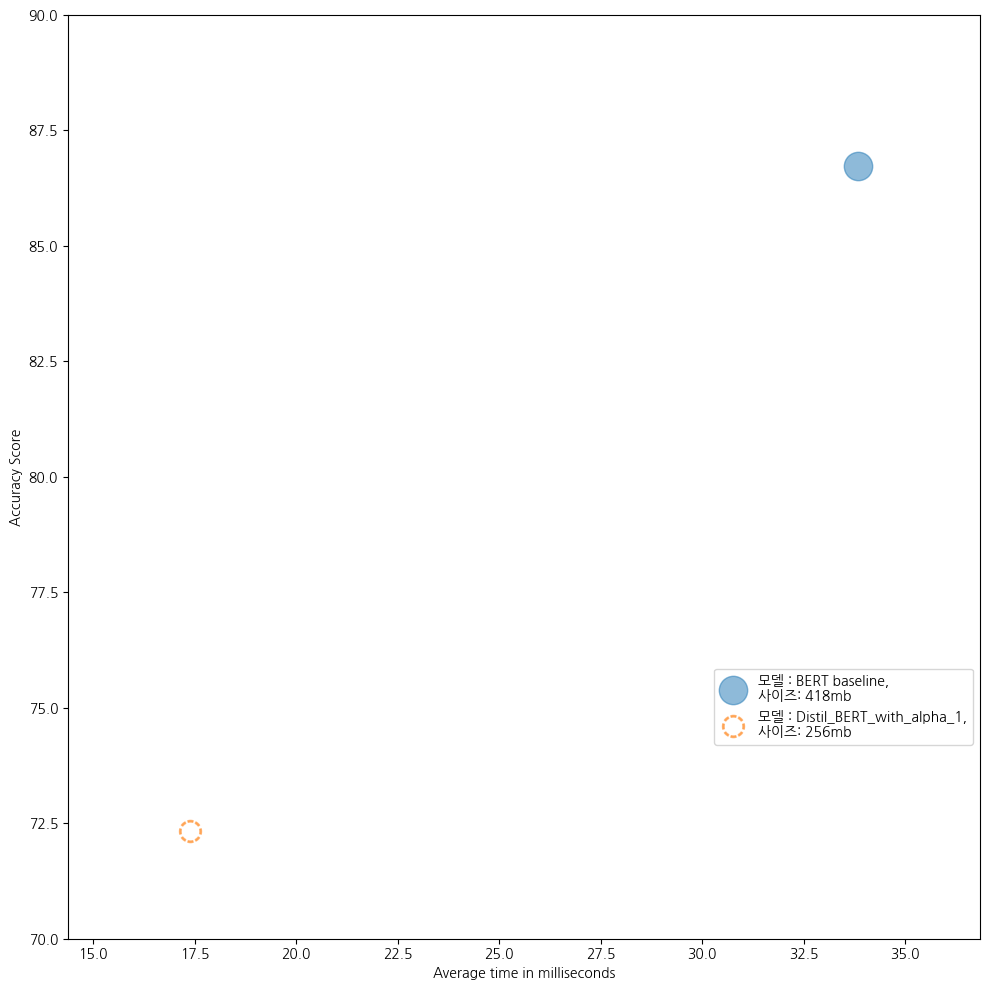

In [25]:
plot_metrics(perf_metrics, optim_type)

### grid search with Optuna

- 예시 로젠부록의 바나 함수 최소값 찾기
    $$ f(x,y) = (1-x)^2 + 100(y-x^2)^2 $$
    최소 값은 (x, y) = (1, 1)

In [ ]:
# example
import optuna

def banana(trail):
    x = trail.suggest_float("x", -2, 2)
    y = trail.suggest_float("y", -2, 2)
    return (1-x) ** 2 + 100 * (y-x ** 2) ** 2

study = optuna.create_study()
study.optimize(banana, n_trials=1000)

study.best_params

### hyperparameter 찾기

In [ ]:
def hp_space(trail):
    return {"num_train_epochs" : trail.suggest_int("num_train_epoch", 5, 10),
            "alpha" : trail.suggest_float("alpha", 0, 1),
            "temperature" : trail.suggest_int("temperature",2, 20)}

best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space
)

In [41]:
print(best_run.hyperparameters)

{'num_train_epoch': 9, 'alpha': 0.16484386886358915, 'temperature': 2}


In [ ]:
# 매개변수 바꾸기
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args,k,v)

In [53]:
distilled_ckpt = "distilbert-base-uncased-finetuned-clinic-best"
student_training_args.output_dir = distilled_ckpt

distilbert_trainer = DistillationTrainer(model_init=student_init,
                                         teacher_model=teacher_model,
                                         args = student_training_args,
                                         train_dataset = clinic_enc['train'],
                                         eval_dataset = clinic_enc['validation'],
                                         compute_metrics=compute_metrics,
                                         tokenizer=student_tokenizer)

distilbert_trainer.train()

/tmp/ipykernel_1919/3768645800.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.864051,0.709355
2,1.149700,0.400230,0.870323
3,1.149700,0.238067,0.911290
4,0.387300,0.189278,0.931290
5,0.204700,0.171596,0.933871
6,0.204700,0.163238,0.938710
7,0.165000,0.158935,0.939355
8,0.151000,0.156061,0.940000
9,0.151000,0.155195,0.940968


TrainOutput(global_step=2862, training_loss=0.3781438263707191, metrics={'train_runtime': 367.2666, 'train_samples_per_second': 373.707, 'train_steps_per_second': 7.793, 'total_flos': 745151547572796.0, 'train_loss': 0.3781438263707191, 'epoch': 9.0})

In [54]:
distilbert_trainer.push_to_hub("best param with knoledge disllation.")

CommitInfo(commit_url='https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-clinic-best/commit/468d04ce550c651a4c7acb57ba4e587784d95736', commit_message='best param with knoledge disllation.', commit_description='', oid='468d04ce550c651a4c7acb57ba4e587784d95736', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tommyjin/distilbert-base-uncased-finetuned-clinic-best', endpoint='https://huggingface.co', repo_type='model', repo_id='tommyjin/distilbert-base-uncased-finetuned-clinic-best'), pr_revision=None, pr_num=None)

In [26]:
# model with out knoledge distil
finetuned_ckpt = "tommyjin/distilbert-base-uncased-finetuned-clinic-best"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=device)

optim_type="Distil_BERT_with_best_parm"
pb = PerformanceBenchMark(pipe, clinic["test"],optim_type)

Device set to use cpu


In [27]:
perf_metrics.update(pb.run_benchmark())

모델 크기 (mb) - 255.88
평균 레이턴시(ms) : 17.77 +/- 2.42 (표준편차) 
정확도 : 0.868727


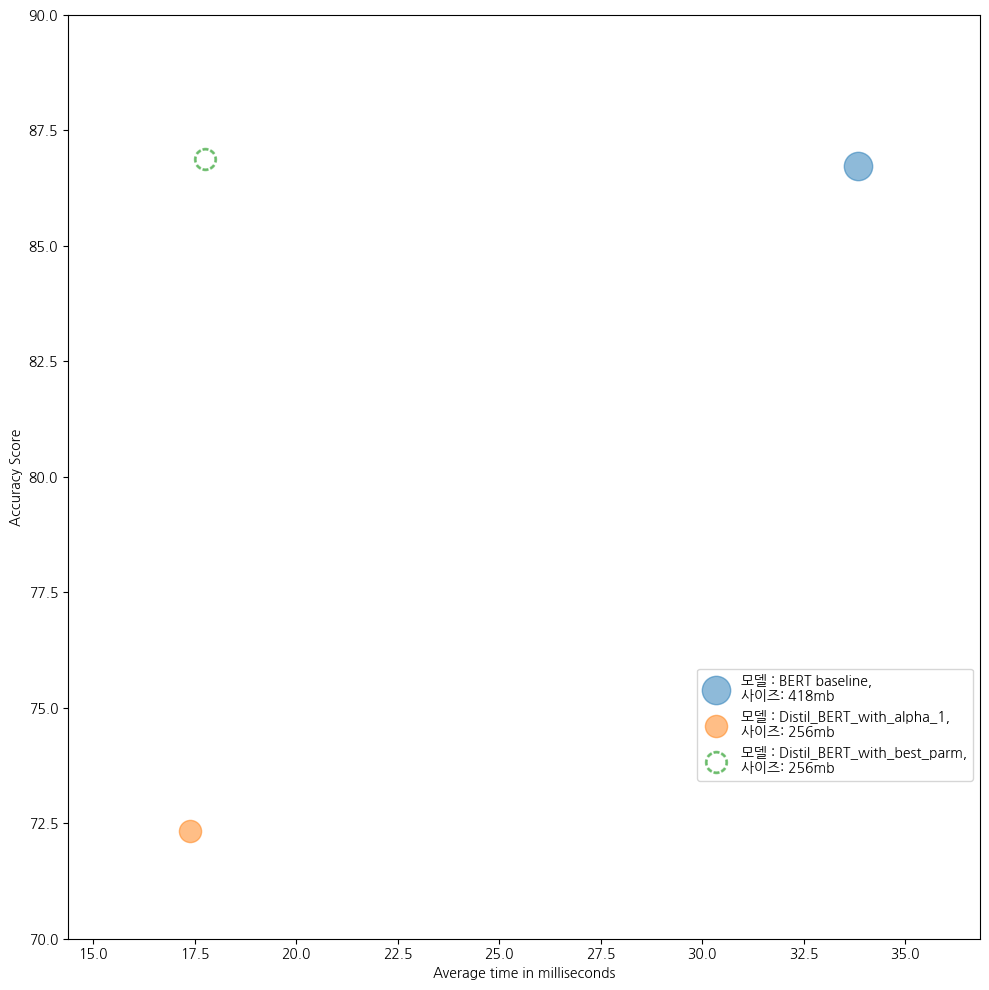

In [28]:
plot_metrics(perf_metrics, optim_type)

- The knowledge-distilled model performs even better than the teacher model.

### 양자화 하기(Quantization)

- 일반으로 FP32 or FP16 or both 인 부동소수점 를 이용하는 대신 int8 와 같이 정밀도는 낮지만 빠른 계산과 모델의 경량화
    - 부동 소수점(floating point) $$ 부호 + 유효숫자 + 지수 $$ $$ (-1)^0 \times 1.5 \times 10^2 $$

- 기본적인 양자화 공식(이산화 discretize) $$ f = \left( \frac{f_{max}-f_{min}}{q_{max} - q_{min}} \right)(q-Z)=S(q-Z)$$
    - 원래의 범위 : $[f_{max},f_{min}]$
    - 양자화 범위 : $[q_{max},q_{min}]$
    - S : 스케일 인자 (양의 부동 소수점 숫자)
    - f : 원래의 부동 소수점 값
    - Z : zero point
    - q : 양자화 값 $$q = \text{round} \left( \frac{f}{S} \right)+Z$$


![quant_img](./images/08_01.png)

- 어텐션 레이어의 양자화 예시

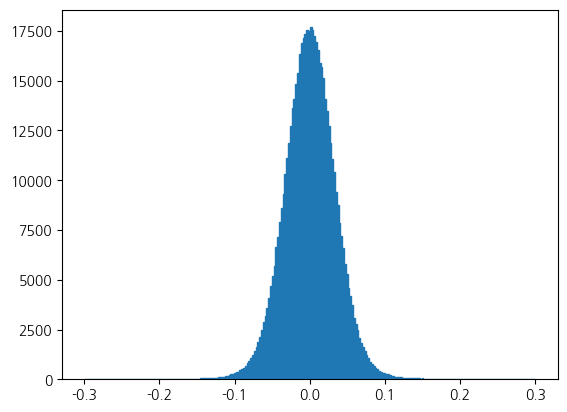

In [ ]:
import matplotlib.pyplot as plt

# 1. 기본 어텐션 레이어 그래프
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"].to("cpu")
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

8 비트 : $ [-2^7 ,2^7-1] = [-128, 127] $ <br>
4 비트 : $ [-2^3 ,2^3-1] = [-8, 7] $

In [66]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128)) # 8 비트로 양자화 시 매핑 범위[-128 ~ 127]
scale # scale factor

tensor(0.0053)

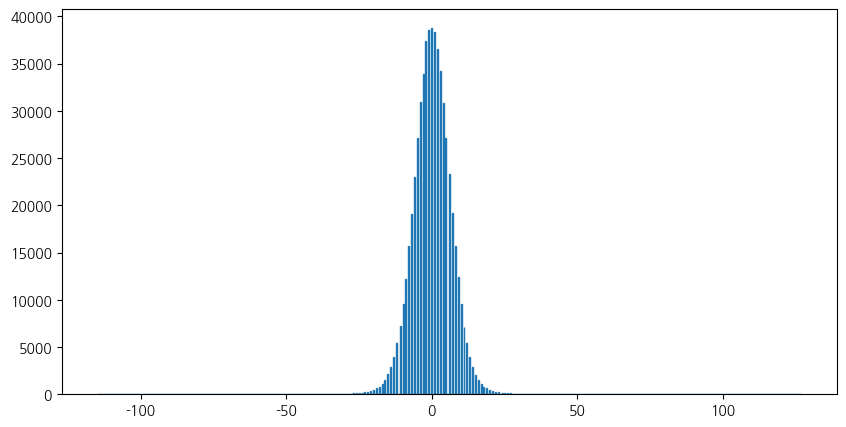

In [157]:
from torch import quantize_per_tensor

quantized_weight = quantize_per_tensor(weights, scale, zero_point, torch.qint8)
quantized_weight_repr = quantized_weight.int_repr() # 그래프에 그리기 위한 역 양자화 상위 매핑

fig, ax = plt.subplots(figsize=(10,5))
# 2. 양자화 된 어텐션 레이어 웨이트 분포 그래프
plt.hist(quantized_weight_repr.flatten(),
         bins=len(quantized_weight_repr.unique())*5,
         edgecolor="C0")
plt.show()

In [ ]:
%%timeit
weights.to("cuda") @ weights.to("cuda")

4 ms ± 234 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [284]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [288]:
%%timeit
q_fn.mul(quantized_weight, quantized_weight).to("cuda")

59.5 μs ± 7.36 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [292]:
print(0.04 / 0.0000595, "배 빠르다")

672.2689075630252 배 빠르다


- 파이토치의 양자연산을 위한 아키텍쳐
    - AVX2 or 이상의 x86 CPU
    - ARM CPU

- 텐서 저장 크기 확인

In [318]:
from IPython.display import Markdown
import sys

# 계산된 결과
a = sys.getsizeof(weights.storage())
b = sys.getsizeof(quantized_weight.storage())

# Markdown 출력
Markdown(f"저장공간 차지 약 $ \\frac{{{a}}}{{{b}}} $ : {a / b:0.2f} 배")

저장공간 차지 약 $ \frac{2359352}{589880} $ : 4.00 배

### 다양한 종류의 양자화
- 동적 양자화 : 
    - 추론 과정에서의 양자화
    - 추론 전에 int8 로 변환.
- 정적 양자화 :
    - 훈련중 양자화가 적용(주로 가중치 양자화)
    - 양자화 체계를 (scheme)을 사전정의 -> 부동 소수점 변환을 피한다.
    - 훈련과 추론의 정밀도 차이로 인해 정확도가 떨어질 수 있다. 

In [29]:
from torch.quantization import quantize_dynamic

# 모델과 토크나이저 로딩
finetuned_ckpt = "tommyjin/distilbert-base-uncased-finetuned-clinic-best"
tokenizer = AutoTokenizer.from_pretrained(finetuned_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(finetuned_ckpt).to("cpu")

# 양자화를 수행할 레이어를 리니어 계층으로 지정
# 여기서는 모델의 모든 Linear 레이어만 양자화
quantized_model = quantize_dynamic(
    model, 
    {torch.nn.Linear},  # Linear 층만 양자화
    dtype=torch.qint8    # 양자화 타입 (여기서는 int8)
)

In [30]:
pipe = pipeline("text-classification",
                model=quantized_model,
                tokenizer=tokenizer,
                device=device)

optim_type="Distil_BERT_with_best_parm_quant8"
pb = PerformanceBenchMark(pipe, clinic["test"],optim_type)
perf_metrics.update(pb.run_benchmark())

Device set to use cpu


모델 크기 (mb) - 132.39
평균 레이턴시(ms) : 8.51 +/- 1.19 (표준편차) 
정확도 : 0.878727


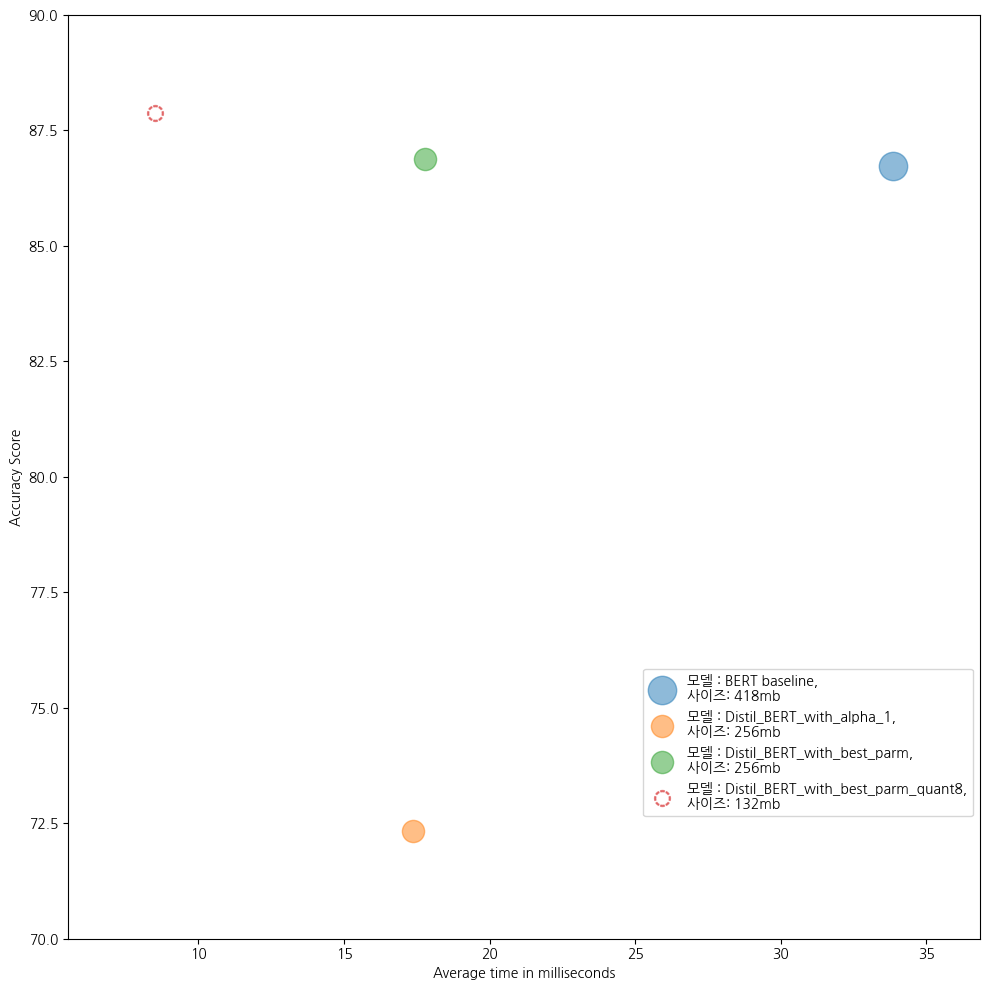

In [31]:
plot_metrics(perf_metrics, optim_type)

### ONNX 런타임을 이용한 추론 최적화
- ORT (Operation fusion) 과 Constant folding 등의 그래프 최적화 도구를 제공
- GPU 나 CPU 에 맞춰 최적화된 세션을 설정한다.

In [ ]:
# pip install onnxruntime
# pip install onnxruntime-genai

In [32]:
import os
from psutil import cpu_count

# cpu 병령 처리를 위한 환경 변수 설정
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVATE"

In [56]:
import torch

# Set the device to CPU
device = torch.device('cpu')
!export CUDA_VISIBLE_DEVICES=""

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [60]:
import torch

torch.cuda.is_available = lambda : False

In [62]:
from transformers.convert_graph_to_onnx import convert
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pathlib import Path

# 모델과 토크나이저 로딩
finetuned_ckpt = "tommyjin/distilbert-base-uncased-finetuned-clinic-best"
tokenizer = AutoTokenizer.from_pretrained(finetuned_ckpt, device=device)
model = AutoModelForSequenceClassification.from_pretrained(finetuned_ckpt).to(device)
onnx_model_path = Path("onnx/model.onnx")

print("CUDA Available:", torch.cuda.is_available()) 

# Convert to ONNX
convert(
    framework="pt",
    model=model,
    tokenizer=tokenizer,
    output=onnx_model_path,
    opset=14,
    pipeline_name="text-classification",
    device=device
)

Device set to use cpu


CUDA Available: False
ONNX opset version set to: 14
Loading pipeline (model: DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [63]:
from onnxruntime import (GraphOptimizationLevel, # 그래프 수준 최적화
                         InferenceSession, # 모델을 로드하고 추론을 수행하는 세션을 생성
                         SessionOptions) # 옵션설정

def create_model_for_provider(model_path, provider = "CPUExecutionProvider"): # provider 기본설정은 cpu
    options = SessionOptions() 
    options.intra_op_num_threads = 1 # 모델 추론시 thread 수
    options.graph_optimization_level = GraphOptimizationLevel.ORT_DISABLE_ALL
    session = InferenceSession(str(model_path), options,  providers=[provider]) # 모델 로드
    session.disable_fallback() # 특정 프로바이더가 아니면 오류를 발생시키게끔
    return session

onnx_model = create_model_for_provider(onnx_model_path)

In [108]:
np.argmax(onnx_model.run(None, {k:v for k,v in clinic_enc["test"][:1].items()
                                if k != "labels"})) , clinic_enc["test"][:1]['labels']

(np.int64(61), [61])

In [147]:
torch.softmax(torch.tensor(np.array([0.2,0.5,0.7])), dim=0)

tensor([0.2501, 0.3376, 0.4123], dtype=torch.float64)

In [160]:
# onnx 추론 및 loss 계산 파이프 라인 만들기
from scipy.special import softmax

class OnnxPipe():
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_input = self.tokenizer(query, return_tensors="pt")
        input_onnx = {k:v.cpu().detach().numpy() for k,v in model_input.items()}
        logits = self.model.run(None, input_onnx)[0][0,:]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label" : intents.int2str(pred_idx),
                 "score" : probs[pred_idx]}]
    
# onnx 벤치 마크 클래스 만들기
class OnnxBench(PerformanceBenchMark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (mb) - {size_mb:.2f}")
        return {"size_mb" : size_mb}

# test pipe
onnx_pipe = OnnxPipe(onnx_model, tokenizer)
onnx_pipe("hello im looking for a car for rent")

[{'label': 'car_rental', 'score': np.float32(0.6914883)}]

In [161]:
optim_type = "distill + ORT with onnx"
pb = OnnxBench(onnx_pipe, clinic["test"], optim_type, model_path="onnx/model.onnx")

In [162]:
perf_metrics.update(pb.run_benchmark())

모델 크기 (mb) - 255.98
평균 레이턴시(ms) : 14.57 +/- 0.19 (표준편차) 
정확도 : 0.868727


In [165]:
# onnx + 양자화 (리니어 층과, 임베딩층의 양자화)
from onnxruntime.quantization import quantize_dynamic, QuantType

model_from = "onnx/model.onnx"
model_to_q8 = "onnx/model.quant8.onnx"
quantize_dynamic(model_from, model_to_q8, weight_type=QuantType.QInt8)

In [166]:
onnx_q8_model = create_model_for_provider(model_to_q8)
onnx_q8_pipe = OnnxPipe(onnx_q8_model, tokenizer)
optim_type = "distil, onnx, ORT(q8)"
pb = OnnxBench(onnx_q8_pipe, clinic["test"], optim_type, model_path=model_to_q8)
perf_metrics.update(pb.run_benchmark())

모델 크기 (mb) - 64.37
평균 레이턴시(ms) : 8.64 +/- 0.33 (표준편차) 
정확도 : 0.876727


- onnx 로 얻은 모델은 사이즈가 base 모델 대비 64mb 작고(85% 경량화)
- 속도도 드라마틱 하게 빠르다.

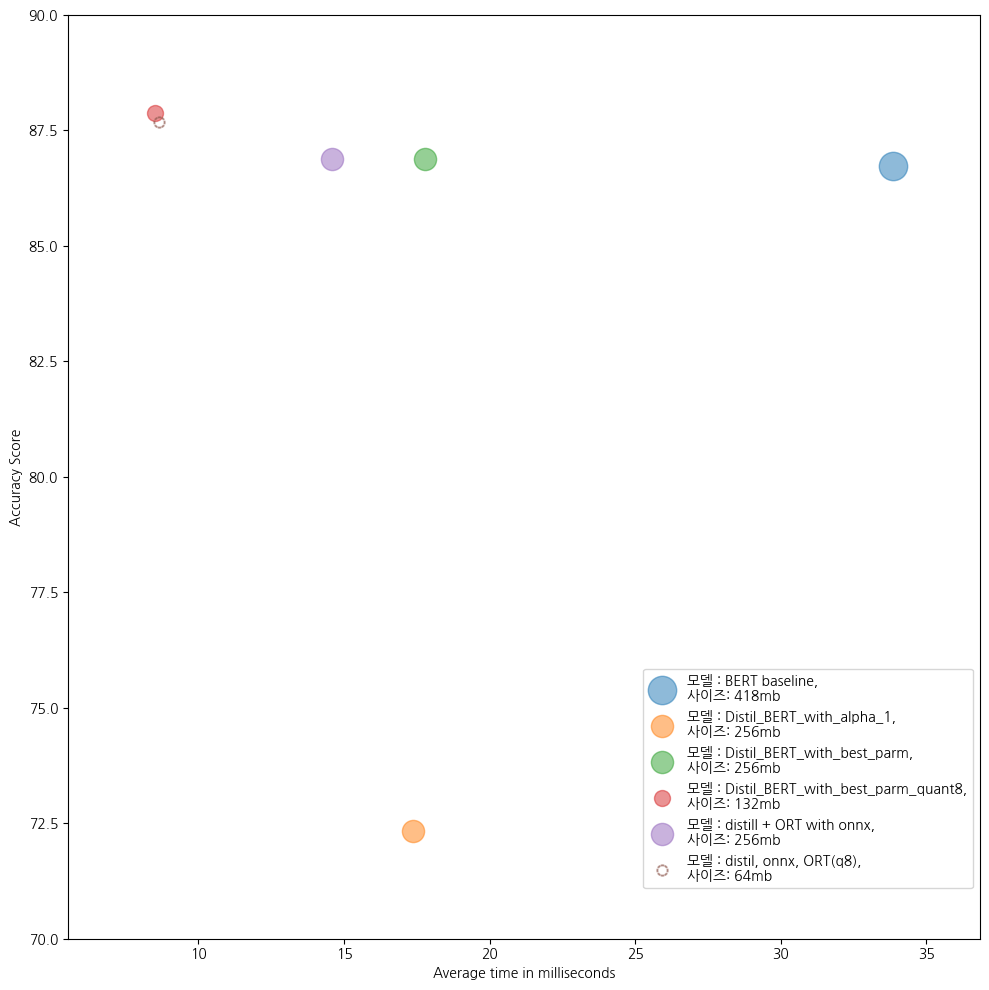

In [167]:
plot_metrics(perf_metrics, optim_type)

In [178]:
# # 현재 까지의 dict 저장하기
# with open("08_perf_metrics.json", "w") as json_file:
#     json.dump(perf_metrics, json_file, indent=4)

In [179]:
# 현재 까지의 dict 저장하기
with open("08_perf_metrics.json", "r") as json_file:
    perf_metrics = json.load(json_file)

### Weight Pruning으로 Sparce 한 모델 만들기

- 가중치 가지치기 : 중요 하지 않은(중요도 점수 기준) 특정 노드의 연결을 끊는다.
- 중요도 점수 : $$ \text{Top}_k (S)_{i,j} =
                \begin{cases}
                 1 & \text{ if 'S' is maximum} \\
                 0 & \text{ else }
                \end{cases} $$
    - 즉 가장 영향력이 높은 k 개의 노드만 1이 되고 나머지는 0 이되는 Onehot vector 와 유사한 희소한 형태가 된다. (k 에 따라 변함)
- 전체 공식 : $$ a_i = \sum_{j} W_{ij} M_{ij} x_{ij} $$
    - $x$ : intput
    - $M$ : $W_{ij}$ 를 1 또는 0으로 만들어주는 마스킹
    - $W$ : Weights

- 다양한 가지치기 종류
    1.	**Magnitude-based Pruning (절대값 가지치기)**
	2.	Random Pruning (랜덤 가지치기)
	3.	Importance-based Pruning (중요도 기반 가지치기)
	4.	Structured Pruning (구조적 가지치기)
	5.	**Dynamic Pruning (Iterative Pruning) (동적 가지치기 / 반복적 가지치기)**
	6.	Layer-wise Pruning (층별 가지치기)
	7.	Sparsity Constraints Pruning (희소성 제약 가지치기)

### Magnitude-based Pruning : 절대값 가지치기
- 가중치의 절대값의 크기에 따라 점수 계산후 마스크를 만들고, 원하는 희소성에 도달할 때 까지 반복
    - $S=(|W_{ij}|)_{i \leq j, j \leq n}$
    - $M=\text{Top}_k (S)$
- 단점 : 계산량이 많다. 매단계마다 모델을 훈련시켜 수렴시켜야 한다.(그러므로 점진적으로 증가시키는 편이 낫다.)
    $$ s_t = s_f + (s_i - s_f) \left( 1-\frac{t - t_0}{N \Delta t} \right)$$
    - 여기서 $t \in \{t_0, t_0 + \Delta t\, ... N \Delta t \} $
    - s : 중요도 점수 (점진적으로 증가함)

### Dynamic Pruning (Iterative Pruning) : 동적 가지치기
- 파인 튜닝 과정중에 점진적으로 가중치를 제거해 희소한 모델로 만든다.
- 파인 튜닝중에 가중치와 점수(s) 값또한 학습이 된다.
- $S$ 도 역시 경사 하강법을 통해 학습이 된다.
- $S$ 학습이 끝난 후에 $M=\text{top}_k (S)$ 를 이용하여 간단하게 마스크를 생성한다.
